**Repository**: https://github.com/EstebanMqz/SP500-Risk-Optimized-Portfolios-PostCovid-ML

### <font color= 'orange'> **S & P 500 Risk Optimized Portfolios PostCovid ML** <font> 

In [2]:
#Import dependencies
import functions as fn
import data as dt
import visualizations as vs

#Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("dark_background")
%matplotlib inline

import scipy
import scipy.stats as st
from scipy import optimize
from scipy.optimize import minimize

import sklearn
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV 
from sklearn import metrics

from yahoofinancials import YahooFinancials 
from tabulate import tabulate
import IPython.display as d

import datetime 
import time

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)

##### <span style='color:red'> Project Creators:</span> Create requirements.txt file.<br>

In [ ]:
docstring = """
# -- --------------------------------------------------------------------------------------------------  -- # 
# -- project: S&P500-Risk-Optimized-Portfolios-PostCovid-ML                                              -- # 
# -- script: requirements.txt: txt file to download Python modules for execution                         -- # 
# -- author: EstebanMqz                                                                                  -- # 
# -- license: CC BY 3.0                                                                                  -- # 
# -- repository: SP500-Risk-Optimized-Portfolios-PostCovid-ML/blob/main/requirements.txt                 -- #                                  
# -- --------------------------------------------------------------------------------------------------  -- # 
\n
"""

fn.get_requirements(docstring)

##### <span style='color:green'> Project Users:</span> Install libraries in requirements.txt file.<br>

In [ ]:
dt.library_install("requirements.txt")

*Fetching a lot of data from Yahoo Finance by batches is required to avoid host disruptions. Other sources could be used too.*<br>

In [2]:
tickers=fn.SP500_tickers(50)
tickers[0][:5], tickers[-1][-5:]

(['MMM', 'AOS', 'ABT', 'ABBV', 'ACN'], ['ZBH', 'ZION', 'ZTS'])

##### <span style='color:lightgray'> Fetching S&P 500 data </span>
takes 5-10 min. for 10y.<br><br>
<span style='color:yellow'> *(skip to read-only .csv)*.



In [ ]:
data = pd.concat([dt.get_historical_price_data(tickers[i][j], 6) for i in range(0, len(tickers)) for j in range(0, len(tickers[i]))], axis=1)

In [ ]:
data.head()

In [ ]:
data.tail()
data.to_csv("sp500.csv")

<span style='color:lightgreen'> Read-only .csv </span> <br> 

Now that we have downloaded our $data_{17_{05}-23_{05}}$ we can start analyzing it with by calculating $R_{yr}$, $\sigma_{yr}$ and the following *risk-return* $Ratios$ with their respective $\beta$. <br>

$Beta = \frac{Cov(R_{p},R_{mkt})}{Var(R_{mkt})}$ <br><br>

$R_{Sharpe} = \frac{Returns - {rf}}{\sigma}$ ,&nbsp;&nbsp; $R_{Sortino} = \frac{Returns - {rf}}{\sigma_{downside}}$ ,&nbsp;&nbsp; $R_{Treynor} = \frac{Returns - {rf}}{\beta}$ ,&nbsp;&nbsp; $R_{Jensen} = {rf} + \beta(R_{mkt} - {rf})$ <br><br>

,Annualized Return,Volatility,Sharpe Ratio,Sortino Ratio
ENPH,1.518291,0.789591,1.901479,3.293286
TDG,0.451852,0.255364,1.703261,2.788401
DXCM,0.786397,0.501397,1.534707,2.616126
CMG,0.602974,0.364806,1.606536,2.569614
AMD,0.920863,0.585987,1.542632,2.404627
CSGP,0.405487,0.268307,1.448293,2.364980
PAYC,0.688312,0.395736,1.696613,2.363065
FICO,0.500005,0.287623,1.679648,2.311393
KEYS,0.504359,0.319989,1.523362,2.273103
ZTS,0.344071,0.221555,1.476701,2.238899


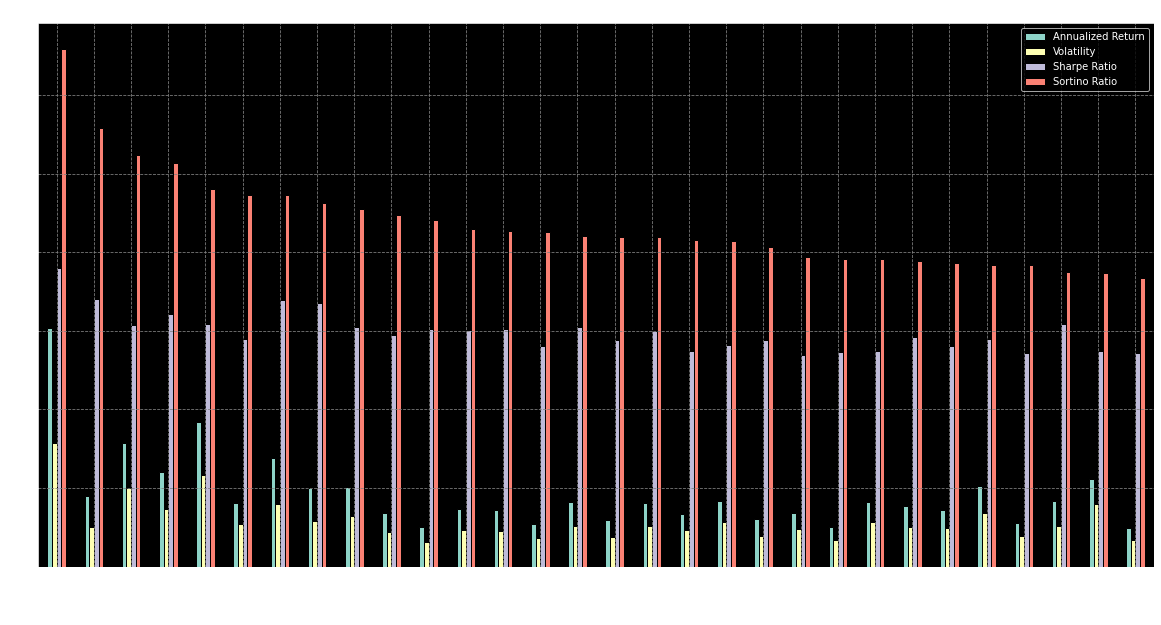

In [3]:
SP_Assets = pd.read_csv("Data/sp500.csv", index_col=0)
Asset_Selection18_20 = vs.selection_data(SP_Assets.loc["2018-01-02":"2020-01-02"], 0.0169, "S&P500 Asset Selection 2018-2020")[0]

Asset_Selection18_20

For $i = 1,2,3,...n$ samples if $x_i$ ~ $N(\mu, \sigma^2)$ then: <br>

in an equally weighted dataset we *would* have the following params : <br><br>

$$\mu_{{x_{i}}}, \sigma_{i} = \frac{1}{n} \bigg(\sum_{i=1}^{n} \mu_{{x_{i}}}, \sqrt{\sum_{i=1}^{n}\left(\mu_{{x_{i}}}-\bar{\mu}\right)^{2}}\bigg)$$
<br>

In a weighted dataset with unknown distributions, weights are:<br>

$$\sum_{n}^{} w=1$$

For *i.i.d* randomly generated variables $\forall x_i \in X_{i}\sim U(0,1)$<br>
with the property $E(X+Y) = E(X) + E(Y)$, the best estimator for $\mu_{p}$ is easily obtained: <br>


$$\mu_{P} = \frac{1}{n} \sum_{i=1}^{n} w_{i} \sum_{i=1}^{n} \mu_{{x_{i}}} = \sum_{i=1}^n (w_i) \mu_{{x_{i}}}$$ 

To calculate $\sigma_p$ we need the variance of the sum of the random variables: <br>

$$\sigma_{P} = \sqrt{\sum_{i=1}^{n} w_{i}^{2} \sigma_{i}^{2} + \sum_{i=1}^{n} \sum_{j=1, j \neq i}^{n} w_{i} w_{j} \sigma_{i} \sigma_{j} \rho_{i j}}$$

where $\rho_{i j} = \frac{Cov(X_i, X_j)}{\sigma_{i} \sigma_{j}}$ is the correlation coefficient.

So it can be reduced to $\sigma_{P} = \sqrt{w^{T} \times COV_{1,n} \times w}$ and solved as a product of matrices $\times$ vectors: <br><br><br>

$$\sigma_{P} = \sqrt{\left[\begin{array}{cccc}w_{1} & w_{2} & \cdots & w_{n}\end{array}\right] \cdot \left[\begin{array}{cccc}1 & \rho_{1,2} & \cdots & \rho_{1,n} \\ \rho_{2,1} & 1 & \cdots & \rho_{2,n} \\ \vdots & \vdots & \ddots & \vdots \\ p_{n,1} & \cdots & \cdots & 1\end{array}\right] \cdot \left[\begin{array}{cccc}w_{1} \\ w_{2} \\ \vdots \\ w_{n}\end{array}\right]}$$

where $\beta$ = $ \frac{Cov(r_{P},r_{mkt})}{Var(r_{mkt})}$ <br><br>

Therefore, we can verify that the following are the optimized portfolios:
+ $Sharpe_{Arg_{max}} \bigg(E\bigg[\frac{r_P}{\sigma}\bigg]\bigg)$ : <br><br>
+ $Min_{Var{Arg_{max}}}$ :<br><br>
+ $Sortino_{Arg_{max}} \bigg(E\bigg[\frac{r_P}{\sigma_{(r_p)<0}}\bigg]\bigg)$ : <br><br>
+ $Traynor_{Arg_{max}} \bigg(E\bigg[\frac{r_P}{\beta}\bigg]\bigg)$ : <br><br>

on given periods

In [4]:
def Optimizer(Assets, index, rf, title):
    Asset_ret = (Assets.pct_change()).iloc[1:, :].dropna(axis = 1)
    index_ret = index.pct_change().iloc[1:, :].dropna(axis = 1)
    index_ret = index_ret[index_ret.index.isin(Asset_ret.index)]

    mean_ret = Asset_ret.mean() * 252
    cov = Asset_ret.cov() * 252

    N = len(mean_ret)
    w0 = np.ones(N) / N
    bnds = ((0, None), ) * N
    cons = {"type" : "eq", "fun" : lambda weights : weights.sum() - 1}

    def Max_Sharpe(weights, Asset_ret, rf, cov):
        rp = np.dot(weights.T, Asset_ret)
        sp = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        RS = (rp - rf) / sp
        return -(np.divide(np.subtract(rp, rf), sp))
    
    def Min_Var(weights, cov):
        return np.dot(weights.T, np.dot(cov, weights)) 
    
    #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    opt_EMV = optimize.minimize(Max_Sharpe, w0, (mean_ret, rf, cov), 'SLSQP', bounds = bnds,
                                constraints = cons, options={"tol": 1e-10})
    
    W_EMV = pd.DataFrame(np.round(opt_EMV.x.reshape(1, N), 4), columns = Asset_ret.columns, index = ["Weights"])
    W_EMV[W_EMV <= 0.0] = np.nan
    W_EMV.dropna(axis = 1, inplace = True)

    RAssets = Asset_ret[Asset_ret.columns[Asset_ret.columns.isin(W_EMV.columns)]]
    # MuAssets = mean_ret[mean_ret.index.isin(W_EMV.columns)]
    R_EMV = pd.DataFrame((RAssets*W_EMV.values).sum(axis = 1), columns = ["$r_{P_{EMV}}$"])
    index_ret.rename(columns={index_ret.columns[0]: "$r_{mkt}$" }, inplace=True)
    R_EMV.insert(1, index_ret.columns[0], index_ret.values)

    Muopt_EMV = np.dot(opt_EMV.x.T, mean_ret) 
    Sopt_EMV = np.sqrt(np.dot(opt_EMV.x.T, np.dot(cov, opt_EMV.x)))
    Beta_EMV = np.divide((np.cov(R_EMV.iloc[0], R_EMV.iloc[1])[0][1]), R_EMV.iloc[1].var())
    SR_EMV = (Muopt_EMV - rf) / Sopt_EMV

    #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------

    opt_MinVar = optimize.minimize(Min_Var, np.ones(N) / N, (cov,), 'SLSQP', bounds = bnds,
                                   constraints = cons, options={"tol": 1e-10})

    W_MinVar = pd.DataFrame(np.round(opt_MinVar.x.reshape(1, N), 4), columns = Asset_ret.columns, index = ["Weights"])
    W_MinVar[W_MinVar <= 0.0] = np.nan
    W_MinVar.dropna(axis = 1, inplace = True)

    RAssets_MinVar = Asset_ret[Asset_ret.columns[Asset_ret.columns.isin(W_MinVar.columns)]]
    R_MinVar = pd.DataFrame((RAssets_MinVar*W_MinVar.values).sum(axis = 1), columns = ["$r_{P_{MinVar}}$"])
    R_EMV.insert(2, R_MinVar.columns[0], R_MinVar.values)

    Muopt_MinVar = np.dot(opt_MinVar.x.T, mean_ret) 
    Sopt_MinVar = np.sqrt(np.dot(opt_MinVar.x.T, np.dot(cov, opt_MinVar.x)))
    Beta_MinVar = np.divide((np.cov(R_EMV.iloc[2], R_EMV.iloc[1])[0][1]), R_EMV.iloc[1].var())
    SR_MinVar = (Muopt_MinVar - rf) / Sopt_MinVar
    #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------

    Mu, Sigma, Beta, SR = [Muopt_EMV, Muopt_MinVar], [Sopt_EMV, Sopt_MinVar], [Beta_EMV, Beta_MinVar], [SR_EMV, SR_MinVar]
    index = ["$EMV_{Arg_{max}}$", "$Min_{Var_{Arg_{max}}}$"]
    Popt = [pd.DataFrame({"$\mu_P$" : Mu[i], "$\sigma_P$" : Sigma[i], "$\Beta_{P}$": Beta[i], "$Sharpe-R_{max}$" : SR[i]},
                          index = [index[i]]) for i in range(0, len(Mu))]
    
    Popt[0].index.name = title
    Popt[1].index.name = title
    R_EMV = R_EMV[[R_EMV.columns[1], R_EMV.columns[0], R_EMV.columns[2]]]
    #Get the cumulative returns with cumsum for rmkt, rEMV and rMinVar
    accum = R_EMV.cumsum()

    Argmax = [d.Markdown(tabulate(Popt[i], headers = "keys", tablefmt = "pipe")) for i in range(0, len(Popt))]
    R_EMV = d.Markdown(tabulate(R_EMV, headers = "keys", tablefmt = "pipe"))
    
    return Argmax, R_EMV, accum

In [5]:
Argmax, R_EMV, accum = Optimizer(SP_Assets.loc["2020-03-02":"2023-05-05"], dt.get_historical_price_data('^GSPC', 6).loc["2020-03-02":"2023-05-05"], 0.0169, "$S\&P500_{18-20}$")
d.display(Argmax[0], Argmax[1], R_EMV)

| $S\&P500_{18-20}$   |   $\mu_P$ |   $\sigma_P$ |   $\Beta_{P}$ |   $Sharpe-R_{max}$ |
|:--------------------|----------:|-------------:|--------------:|-------------------:|
| $EMV_{Arg_{max}}$   |  0.493792 |     0.234162 |      -2.24604 |            2.03659 |

| $S\&P500_{18-20}$       |   $\mu_P$ |   $\sigma_P$ |   $\Beta_{P}$ |   $Sharpe-R_{max}$ |
|:------------------------|----------:|-------------:|--------------:|-------------------:|
| $Min_{Var_{Arg_{max}}}$ | 0.0958408 |     0.148769 |      -4.80879 |           0.530626 |

| formatted_date   |    $r_{mkt}$ |   $r_{P_{EMV}}$ |   $r_{P_{MinVar}}$ |
|:-----------------|-------------:|----------------:|-------------------:|
| 2020-03-03       | -0.0281079   |    -0.0160629   |       -0.018947    |
| 2020-03-04       |  0.0422026   |     0.0368398   |        0.0365029   |
| 2020-03-05       | -0.0339221   |    -0.000977998 |       -0.0124711   |
| 2020-03-06       | -0.0170539   |    -0.00157093  |       -0.00840224  |
| 2020-03-09       | -0.0759697   |    -0.0569679   |       -0.0357634   |
| 2020-03-10       |  0.0493963   |     0.0206961   |        0.0201584   |
| 2020-03-11       | -0.0488684   |    -0.0299873   |       -0.0334332   |
| 2020-03-12       | -0.0951127   |    -0.0660963   |       -0.0590342   |
| 2020-03-13       |  0.0928712   |     0.0912858   |        0.0425584   |
| 2020-03-16       | -0.119841    |    -0.0506705   |       -0.0488519   |
| 2020-03-17       |  0.0599548   |     0.0607786   |        0.0622243   |
| 2020-03-18       | -0.0518308   |    -0.0360412   |       -0.0222588   |
| 2020-03-19       |  0.00470781  |    -0.00929838  |        0.000721469 |
| 2020-03-20       | -0.0433595   |    -0.0423746   |       -0.0338615   |
| 2020-03-23       | -0.0292939   |    -0.0553674   |       -0.0140176   |
| 2020-03-24       |  0.0938277   |     0.0699746   |        0.0333672   |
| 2020-03-25       |  0.011535    |     0.0177437   |       -0.00931067  |
| 2020-03-26       |  0.0624142   |     0.0418769   |        0.0487126   |
| 2020-03-27       | -0.0336874   |    -0.00601095  |       -0.00692051  |
| 2020-03-30       |  0.033516    |     0.026499    |        0.0267766   |
| 2020-03-31       | -0.0160127   |     0.00293768  |       -0.00727915  |
| 2020-04-01       | -0.0441424   |    -0.0200376   |       -0.00940346  |
| 2020-04-02       |  0.0228293   |     0.0437305   |        0.0195764   |
| 2020-04-03       | -0.0151371   |     0.0141961   |        0.000305192 |
| 2020-04-06       |  0.0703313   |     0.051847    |        0.036129    |
| 2020-04-07       | -0.00160305  |     0.00256358  |       -0.00479277  |
| 2020-04-08       |  0.0340565   |     0.0203367   |        0.0139483   |
| 2020-04-09       |  0.0144874   |     0.0106179   |        0.00659859  |
| 2020-04-13       | -0.0101047   |     0.0151655   |        0.000125686 |
| 2020-04-14       |  0.0305726   |     0.0353286   |        0.0249233   |
| 2020-04-15       | -0.0220304   |    -0.00398295  |       -0.00333407  |
| 2020-04-16       |  0.00581669  |     0.0190426   |        0.0170836   |
| 2020-04-17       |  0.0267936   |     0.0430417   |        0.0103541   |
| 2020-04-20       | -0.017881    |     0.0195747   |        0.000211595 |
| 2020-04-21       | -0.0306748   |    -0.0248676   |       -0.0167495   |
| 2020-04-22       |  0.0229302   |     0.0163107   |        0.0140514   |
| 2020-04-23       | -0.000539422 |    -0.00753237  |       -0.00592399  |
| 2020-04-24       |  0.0139181   |     0.0225256   |        0.00744596  |
| 2020-04-27       |  0.0147141   |     0.00944176  |        0.0048694   |
| 2020-04-28       | -0.00524238  |    -0.00646958  |       -0.00395935  |
| 2020-04-29       |  0.0265839   |     0.00903699  |       -0.00101686  |
| 2020-04-30       | -0.00921245  |    -0.00821124  |       -0.00873997  |
| 2020-05-01       | -0.028059    |    -0.0115117   |       -0.00675853  |
| 2020-05-04       |  0.00424983  |     0.0144032   |        0.00329906  |
| 2020-05-05       |  0.00904056  |     0.00187158  |        0.0116121   |
| 2020-05-06       | -0.00697941  |    -0.0118023   |       -0.00297442  |
| 2020-05-07       |  0.0115046   |     0.00572021  |       -0.000773933 |
| 2020-05-08       |  0.0168715   |     0.0295866   |        0.0114959   |
| 2020-05-11       |  0.000133078 |     0.00814246  |        0.00685333  |
| 2020-05-12       | -0.0205003   |    -0.020265    |       -0.00832103  |
| 2020-05-13       | -0.0174627   |    -0.00582165  |       -0.000230396 |
| 2020-05-14       |  0.0115248   |     0.00228179  |        0.000290406 |
| 2020-05-15       |  0.00392636  |     0.0113664   |        0.00167118  |
| 2020-05-18       |  0.0315012   |     0.0380225   |        0.00659509  |
| 2020-05-19       | -0.0104844   |    -0.0144059   |       -0.00847998  |
| 2020-05-20       |  0.0166511   |     0.00885466  |        0.00696513  |
| 2020-05-21       | -0.0077736   |    -0.0135528   |       -0.0153664   |
| 2020-05-22       |  0.00235371  |     0.00872924  |        0.00354026  |
| 2020-05-26       |  0.0122892   |    -0.00107584  |       -0.0111627   |
| 2020-05-27       |  0.0148273   |    -0.00324699  |        0.0164545   |
| 2020-05-28       | -0.00210791  |     0.00168359  |        0.00437588  |
| 2020-05-29       |  0.00481234  |     0.0199666   |        0.0201273   |
| 2020-06-01       |  0.00375123  |     0.00708     |       -0.00167284  |
| 2020-06-02       |  0.00821083  |     0.00764093  |        0.00240494  |
| 2020-06-03       |  0.013649    |     0.00515601  |       -0.00424569  |
| 2020-06-04       | -0.0033687   |     0.00176438  |        0.000636264 |
| 2020-06-05       |  0.0262117   |     0.0113327   |        6.52728e-05 |
| 2020-06-08       |  0.0120416   |     0.0278293   |        0.0117256   |
| 2020-06-09       | -0.00779917  |    -0.0126431   |       -0.005337    |
| 2020-06-10       | -0.00531309  |    -0.0116664   |        0.00310588  |
| 2020-06-11       | -0.0589441   |    -0.0396631   |       -0.0333144   |
| 2020-06-12       |  0.0130608   |     0.00503736  |       -0.00447517  |
| 2020-06-15       |  0.00831222  |     0.011317    |        0.00611027  |
| 2020-06-16       |  0.0189624   |     0.0387244   |        0.0115301   |
| 2020-06-17       | -0.0036003   |    -0.0102359   |        0.00168545  |
| 2020-06-18       |  0.00059422  |    -0.000897018 |       -0.000585901 |
| 2020-06-19       | -0.00564949  |    -0.00485509  |        0.00391304  |
| 2020-06-22       |  0.0064951   |    -0.00335456  |        0.00105638  |
| 2020-06-23       |  0.00430742  |    -0.00325854  |       -0.004998    |
| 2020-06-24       | -0.0258551   |    -0.0176737   |       -0.0119371   |
| 2020-06-25       |  0.0109594   |     0.00567095  |        0.00273817  |
| 2020-06-26       | -0.0242269   |    -0.0186814   |       -0.0133295   |
| 2020-06-29       |  0.0146857   |     0.0180223   |        0.0150345   |
| 2020-06-30       |  0.0154099   |     0.0172988   |        0.00902921  |
| 2020-07-01       |  0.00502213  |    -0.0155203   |        0.00172593  |
| 2020-07-02       |  0.00454125  |     0.0149476   |        0.0013244   |
| 2020-07-06       |  0.0158817   |     0.0251655   |        0.00887029  |
| 2020-07-07       | -0.0108185   |     0.00413     |        0.00246103  |
| 2020-07-08       |  0.00782746  |     0.00047095  |       -0.000541576 |
| 2020-07-09       | -0.00564361  |    -0.00424     |       -0.00442221  |
| 2020-07-10       |  0.0104662   |     0.00166852  |        0.0100659   |
| 2020-07-13       | -0.00936254  |     0.00521421  |       -0.0048387   |
| 2020-07-14       |  0.0134064   |     0.0303018   |        0.0162168   |
| 2020-07-15       |  0.00908205  |     0.0150623   |        0.00815884  |
| 2020-07-16       | -0.0034061   |    -0.00240767  |        0.00278163  |
| 2020-07-17       |  0.00284861  |     0.0201987   |        0.00578954  |
| 2020-07-20       |  0.00840694  |    -0.0116132   |       -0.0049903   |
| 2020-07-21       |  0.00167904  |     0.00764367  |        0.00067572  |
| 2020-07-22       |  0.00574708  |     0.00489894  |        0.00444376  |
| 2020-07-23       | -0.0123199   |    -0.00438731  |       -0.0006526   |
| 2020-07-24       | -0.0061904   |    -0.00985669  |       -0.0045884   |
| 2020-07-27       |  0.00739514  |     0.00764161  |        0.00949431  |
| 2020-07-28       | -0.00647339  |    -0.000648652 |        0.00382184  |
| 2020-07-29       |  0.0124284   |     0.00906252  |        0.00405435  |
| 2020-07-30       | -0.00375025  |    -0.0215007   |       -0.00605667  |
| 2020-07-31       |  0.0076705   |    -0.0073562   |        0.00106611  |
| 2020-08-03       |  0.00718102  |     0.0279036   |        0.0029734   |
| 2020-08-04       |  0.00361193  |     0.0149871   |        0.0131914   |
| 2020-08-05       |  0.00642974  |     0.0015412   |       -0.00362015  |
| 2020-08-06       |  0.0064277   |    -0.00206524  |        0.00697955  |
| 2020-08-07       |  0.00063303  |     0.022158    |        0.00451138  |
| 2020-08-10       |  0.00274222  |     0.000793869 |        0.00163134  |
| 2020-08-11       | -0.00796913  |    -0.0189411   |       -0.0106132   |
| 2020-08-12       |  0.0139965   |     0.0151721   |        0.0106775   |
| 2020-08-13       | -0.00204717  |    -0.00342643  |        0.00110118  |
| 2020-08-14       | -0.000171883 |     0.00961433  |        0.00103328  |
| 2020-08-17       |  0.00270984  |     0.0117237   |        0.00741458  |
| 2020-08-18       |  0.00230339  |    -0.00416096  |        5.8351e-05  |
| 2020-08-19       | -0.0044044   |     0.000236251 |       -0.00395627  |
| 2020-08-20       |  0.00315863  |    -0.00991509  |       -0.000420715 |
| 2020-08-21       |  0.00344111  |    -0.00400188  |        1.04625e-05 |
| 2020-08-24       |  0.0100437   |     0.00746163  |        0.00600666  |
| 2020-08-25       |  0.00359635  |     0.00333936  |        0.00100752  |
| 2020-08-26       |  0.0101956   |     0.004714    |        0.00414922  |
| 2020-08-27       |  0.00167304  |    -0.00143088  |        0.00171549  |
| 2020-08-28       |  0.00673257  |    -0.00345979  |       -0.000499073 |
| 2020-08-31       | -0.00219496  |    -0.00489454  |       -0.00122488  |
| 2020-09-01       |  0.007525    |     0.000659986 |       -0.0039897   |
| 2020-09-02       |  0.0153659   |     0.00862291  |        0.0123875   |
| 2020-09-03       | -0.0351258   |    -0.0184368   |       -0.017371    |
| 2020-09-04       | -0.00813303  |    -0.000907881 |       -0.00772192  |
| 2020-09-08       | -0.0277563   |    -0.0422088   |       -0.0211439   |
| 2020-09-09       |  0.020145    |     0.0210131   |        0.0135004   |
| 2020-09-10       | -0.0175848   |    -0.0233647   |       -0.0129258   |
| 2020-09-11       |  0.000533072 |     0.00752662  |       -0.00244397  |
| 2020-09-14       |  0.0127418   |     0.0147282   |        0.00777262  |
| 2020-09-15       |  0.00521936  |     0.0109301   |        0.00126407  |
| 2020-09-16       | -0.00461895  |     0.00537662  |       -0.00745843  |
| 2020-09-17       | -0.00841237  |    -0.0137859   |       -0.00327069  |
| 2020-09-18       | -0.0111826   |     0.00508893  |       -0.00256805  |
| 2020-09-21       | -0.0115711   |    -0.0122487   |       -0.00775678  |
| 2020-09-22       |  0.0105179   |    -0.00596275  |        0.00780436  |
| 2020-09-23       | -0.0237215   |    -0.0077808   |       -0.0151718   |
| 2020-09-24       |  0.00298746  |    -0.00227741  |        0.00319649  |
| 2020-09-25       |  0.0159767   |     0.0114596   |        0.0125311   |
| 2020-09-28       |  0.0161106   |     0.0122036   |        0.0067549   |
| 2020-09-29       | -0.00481266  |    -0.01324     |       -0.004924    |
| 2020-09-30       |  0.00825372  |     0.0102401   |        0.00625592  |
| 2020-10-01       |  0.00529291  |    -0.000724021 |        0.00477795  |
| 2020-10-02       | -0.00957765  |     0.00195813  |       -0.00659837  |
| 2020-10-05       |  0.0179727   |     0.0283977   |        0.0104215   |
| 2020-10-06       | -0.0139735   |    -0.0121148   |       -0.00889882  |
| 2020-10-07       |  0.0173968   |     0.0281864   |        0.0120056   |
| 2020-10-08       |  0.00801012  |     0.0132293   |       -7.71827e-05 |
| 2020-10-09       |  0.00879353  |     0.00868955  |        0.00337424  |
| 2020-10-12       |  0.0164158   |     0.011802    |        0.00869267  |
| 2020-10-13       | -0.00630692  |     0.00280567  |        0.00330827  |
| 2020-10-14       | -0.00662314  |    -0.0073621   |       -0.00646271  |
| 2020-10-15       | -0.00152776  |     0.00215699  |       -0.00504441  |
| 2020-10-16       |  0.00013492  |    -0.00533772  |        0.000127238 |
| 2020-10-19       | -0.0163299   |    -0.0150722   |       -0.0128654   |
| 2020-10-20       |  0.00472733  |     0.00448818  |       -0.00176843  |
| 2020-10-21       | -0.0021957   |    -0.0157523   |       -0.0030808   |
| 2020-10-22       |  0.00521893  |     0.0106727   |        0.00635201  |
| 2020-10-23       |  0.00344576  |     0.0116916   |        0.0026676   |
| 2020-10-26       | -0.0185895   |    -0.0154464   |       -0.0080812   |
| 2020-10-27       | -0.00302562  |    -0.0146869   |       -0.00501267  |
| 2020-10-28       | -0.0352879   |    -0.00647744  |       -0.0231033   |
| 2020-10-29       |  0.0119473   |     0.00762794  |        0.00323279  |
| 2020-10-30       | -0.0121296   |    -0.0141322   |       -0.0012697   |
| 2020-11-02       |  0.0123182   |     0.0153914   |        0.0126152   |
| 2020-11-03       |  0.0177993   |     0.00528662  |        0.014304    |
| 2020-11-04       |  0.022047    |     0.00809776  |        0.0122649   |
| 2020-11-05       |  0.0194602   |     0.0141673   |        0.00704072  |
| 2020-11-06       | -0.000287715 |     0.00117349  |       -0.00248329  |
| 2020-11-09       |  0.0116999   |    -0.00828372  |       -0.00985531  |
| 2020-11-10       | -0.00139979  |     0.00834745  |        0.0133566   |
| 2020-11-11       |  0.00765186  |     0.0214226   |        0.0114917   |
| 2020-11-12       | -0.00997853  |    -0.00588824  |       -0.00593554  |
| 2020-11-13       |  0.0136103   |     0.0136658   |        0.00982022  |
| 2020-11-16       |  0.0116481   |     0.00866825  |        0.00285302  |
| 2020-11-17       | -0.00479193  |    -0.00733243  |       -0.00805357  |
| 2020-11-18       | -0.0115638   |    -0.00507186  |       -0.0136078   |
| 2020-11-19       |  0.00394644  |     0.0224456   |        0.00375101  |
| 2020-11-20       | -0.00679256  |     5.21066e-07 |       -0.001623    |
| 2020-11-23       |  0.00563593  |     0.0148812   |        0.000615078 |
| 2020-11-24       |  0.0161617   |     0.0139414   |       -0.00105483  |
| 2020-11-25       | -0.00158442  |     0.0054355   |        0.00117126  |
| 2020-11-27       |  0.00239698  |     0.0230204   |        0.0069335   |
| 2020-11-30       | -0.00459555  |     0.0127035   |        0.00509576  |
| 2020-12-01       |  0.0112712   |    -0.00537668  |        0.000888792 |
| 2020-12-02       |  0.00179117  |    -0.00670043  |       -0.00200488  |
| 2020-12-03       | -0.000624157 |     0.00119506  |        0.00138435  |
| 2020-12-04       |  0.00883628  |     0.0151024   |        0.00275212  |
| 2020-12-07       | -0.00193564  |     0.000180048 |        0.000556656 |
| 2020-12-08       |  0.00278715  |     0.00540191  |        0.00301995  |
| 2020-12-09       | -0.0079492   |     0.00484366  |       -0.0053607   |
| 2020-12-10       | -0.00128511  |     0.0104647   |       -0.00520719  |
| 2020-12-11       | -0.001265    |    -0.0059982   |        0.00113851  |
| 2020-12-14       | -0.00435926  |    -0.0103529   |       -0.00352101  |
| 2020-12-15       |  0.0129212   |     0.0197096   |        0.00906391  |
| 2020-12-16       |  0.0017728   |    -0.00524853  |       -8.95192e-05 |
| 2020-12-17       |  0.00575765  |     0.00798472  |        0.00842076  |
| 2020-12-18       | -0.00351112  |    -0.00542636  |        0.00467972  |
| 2020-12-21       | -0.00390628  |    -0.00210703  |       -0.0090209   |
| 2020-12-22       | -0.00207309  |    -0.00552504  |       -0.00408011  |
| 2020-12-23       |  0.000745811 |     0.0106782   |        0.00474225  |
| 2020-12-24       |  0.00353659  |    -0.00404089  |        0.000888943 |
| 2020-12-28       |  0.00872253  |    -0.0229203   |        0.000300291 |
| 2020-12-29       | -0.00222738  |    -0.00362683  |       -0.00365746  |
| 2020-12-30       |  0.00134155  |     0.00616275  |       -0.0010629   |
| 2020-12-31       |  0.00643885  |    -0.00427615  |        0.0061339   |
| 2021-01-04       | -0.0147548   |     0.00511912  |       -0.00462213  |
| 2021-01-05       |  0.0070826   |     0.000750433 |        0.000141832 |
| 2021-01-06       |  0.00570984  |     0.0341261   |        0.00592577  |
| 2021-01-07       |  0.0148474   |     0.00885191  |        0.00313679  |
| 2021-01-08       |  0.00549186  |    -0.00829108  |       -0.00158679  |
| 2021-01-11       | -0.00655475  |     0.0311102   |       -0.000872141 |
| 2021-01-12       |  0.000415788 |     0.0103576   |       -0.00222753  |
| 2021-01-13       |  0.00227564  |     0.0103653   |       -0.00303465  |
| 2021-01-14       | -0.00375345  |     0.0188625   |        0.00456455  |
| 2021-01-15       | -0.00719003  |    -0.00254534  |        0.00216192  |
| 2021-01-19       |  0.00813638  |     0.00255717  |        0.00103223  |
| 2021-01-20       |  0.0139356   |     0.000763574 |        0.00237064  |
| 2021-01-21       |  0.000316723 |     0.00808444  |       -0.00356737  |
| 2021-01-22       | -0.00301061  |     0.00445722  |        0.00179145  |
| 2021-01-25       |  0.00361584  |     0.0193618   |        0.0148513   |
| 2021-01-26       | -0.00148883  |     0.00257075  |        0.00446063  |
| 2021-01-27       | -0.0256779   |    -0.00485145  |       -0.00802867  |
| 2021-01-28       |  0.00976063  |     0.000992053 |       -0.0110804   |
| 2021-01-29       | -0.0193115   |    -0.0118108   |       -0.012731    |
| 2021-02-01       |  0.0160518   |    -0.00443803  |       -0.000332809 |
| 2021-02-02       |  0.0138982   |    -0.00129539  |        0.00812799  |
| 2021-02-03       |  0.00100877  |     0.00969422  |       -0.00340395  |
| 2021-02-04       |  0.0108533   |     0.0100717   |        0.000209013 |
| 2021-02-05       |  0.0038975   |     0.00260754  |        0.00623416  |
| 2021-02-08       |  0.00739935  |     0.019144    |       -0.00130178  |
| 2021-02-09       | -0.00111352  |    -0.00770386  |        0.00348058  |
| 2021-02-10       | -0.000345185 |     0.00158562  |       -0.00220925  |
| 2021-02-11       |  0.00166246  |    -0.00386479  |       -0.00598397  |
| 2021-02-12       |  0.00471103  |     0.0146041   |        0.00368946  |
| 2021-02-16       | -0.000569272 |    -0.00460243  |       -0.00890293  |
| 2021-02-17       | -0.000320402 |     0.00744866  |        0.014165    |
| 2021-02-18       | -0.00441584  |    -0.0186923   |        0.00197533  |
| 2021-02-19       | -0.0018549   |     0.00283516  |       -0.0086033   |
| 2021-02-22       | -0.00773284  |    -0.0205672   |        0.000286099 |
| 2021-02-23       |  0.00125632  |    -0.0023999   |       -0.00231805  |
| 2021-02-24       |  0.0113516   |     0.0101461   |        0.00352956  |
| 2021-02-25       | -0.0244788   |    -0.0115818   |       -0.0133199   |
| 2021-02-26       | -0.00475021  |    -0.000211057 |       -0.0109727   |
| 2021-03-01       |  0.0237908   |     0.0204825   |        0.00593088  |
| 2021-03-02       | -0.00808085  |    -0.0131813   |       -0.00185451  |
| 2021-03-03       | -0.0130662   |    -0.0210199   |       -0.00594308  |
| 2021-03-04       | -0.0134172   |    -0.00862225  |       -0.00523605  |
| 2021-03-05       |  0.019496    |     0.0149825   |        0.0167754   |
| 2021-03-08       | -0.00535923  |    -0.00708595  |        0.00562615  |
| 2021-03-09       |  0.0141546   |     0.0158893   |        0.00718565  |
| 2021-03-10       |  0.00603031  |     0.0137787   |        0.00872829  |
| 2021-03-11       |  0.0103955   |     0.0222836   |       -0.00478237  |
| 2021-03-12       |  0.0010154   |     0.00286075  |        0.0075716   |
| 2021-03-15       |  0.00649192  |    -0.0109697   |        0.00524003  |
| 2021-03-16       | -0.00156968  |     0.00662545  |        0.00269079  |
| 2021-03-17       |  0.00287938  |    -0.0106138   |       -0.000521112 |
| 2021-03-18       | -0.0147605   |    -0.0220705   |       -0.00444209  |
| 2021-03-19       | -0.000602704 |     0.0125752   |        0.00369941  |
| 2021-03-22       |  0.00702512  |     0.0106136   |        0.010726    |
| 2021-03-23       | -0.00763085  |    -0.0200079   |       -0.00101307  |
| 2021-03-24       | -0.00546734  |    -0.0153095   |       -0.0100909   |
| 2021-03-25       |  0.00524027  |     0.019028    |        0.00876783  |
| 2021-03-26       |  0.0166312   |     0.0290011   |        0.0143483   |
| 2021-03-29       | -0.000868013 |    -0.0132597   |        0.00778448  |
| 2021-03-30       | -0.00315783  |    -0.000885524 |       -0.00892695  |
| 2021-03-31       |  0.0036225   |     0.0112538   |       -0.00448183  |
| 2021-04-01       |  0.0118252   |     0.00308877  |        0.00449802  |
| 2021-04-05       |  0.0144382   |    -0.00376711  |        0.0108219   |
| 2021-04-06       | -0.000973531 |     0.006091    |        0.00157279  |
| 2021-04-07       |  0.00147523  |    -0.0106261   |       -0.00314746  |
| 2021-04-08       |  0.00422063  |     0.00129056  |       -0.00147337  |
| 2021-04-09       |  0.00771993  |     0.0051234   |       -0.000654997 |
| 2021-04-12       | -0.000196079 |    -0.00384108  |        0.0045685   |
| 2021-04-13       |  0.00329449  |     0.00760057  |        0.00163023  |
| 2021-04-14       | -0.00408773  |     0.0116196   |       -0.00189494  |
| 2021-04-15       |  0.0110942   |     0.00441547  |        0.00762747  |
| 2021-04-16       |  0.00360882  |     0.0176625   |        0.00721425  |
| 2021-04-19       | -0.00530656  |    -0.00407771  |       -0.000630373 |
| 2021-04-20       | -0.00680232  |    -0.00521954  |        0.00305063  |
| 2021-04-21       |  0.00930606  |     0.0165552   |        0.00376656  |
| 2021-04-22       | -0.00921066  |    -0.00249494  |       -0.00447358  |
| 2021-04-23       |  0.0109287   |     0.00801108  |       -0.00171735  |
| 2021-04-26       |  0.00178227  |     0.00474894  |       -0.0035678   |
| 2021-04-27       | -0.000214896 |     0.000667807 |       -0.00246327  |
| 2021-04-28       | -0.00084554  |     0.000979402 |       -0.00290747  |
| 2021-04-29       |  0.00676281  |     0.00136028  |        0.0029978   |
| 2021-04-30       | -0.00719471  |    -0.0159034   |       -0.0053096   |
| 2021-05-03       |  0.00274809  |     0.0159308   |        0.0098493   |
| 2021-05-04       | -0.00667834  |    -0.00533244  |       -0.00344766  |
| 2021-05-05       |  0.000703464 |     0.00217721  |        0.00238146  |
| 2021-05-06       |  0.00816546  |    -0.0019051   |        0.0107665   |
| 2021-05-07       |  0.00737334  |     0.0212836   |        0.00115396  |
| 2021-05-10       | -0.0104356   |    -0.00262074  |        0.0060523   |
| 2021-05-11       | -0.00867391  |    -0.00595271  |       -0.00238426  |
| 2021-05-12       | -0.0214494   |    -0.0207176   |       -0.00631011  |
| 2021-05-13       |  0.0121731   |     0.00414303  |        0.00913626  |
| 2021-05-14       |  0.014918    |     0.0227871   |        0.00388031  |
| 2021-05-17       | -0.00253005  |     0.00419418  |       -0.00145821  |
| 2021-05-18       | -0.00851729  |    -0.00854546  |       -0.000760182 |
| 2021-05-19       | -0.00294341  |    -0.00663946  |       -0.0033218   |
| 2021-05-20       |  0.0105547   |     0.0120131   |        0.0113734   |
| 2021-05-21       | -0.000783881 |    -0.00023121  |       -0.00121584  |
| 2021-05-24       |  0.00991129  |    -0.00175273  |        0.00432712  |
| 2021-05-25       | -0.00212528  |    -0.0054246   |       -0.00413004  |
| 2021-05-26       |  0.00187682  |     0.0135841   |        0.000810569 |
| 2021-05-27       |  0.00116531  |    -0.000877602 |       -0.00258471  |
| 2021-05-28       |  0.000768882 |     0.00526662  |        0.00368005  |
| 2021-06-01       | -0.000492334 |     0.00842638  |       -0.00148828  |
| 2021-06-02       |  0.00144693  |     0.00329459  |        0.00462115  |
| 2021-06-03       | -0.0036287   |     0.00147178  |        0.00105543  |
| 2021-06-04       |  0.0088341   |     0.00724127  |        0.00654793  |
| 2021-06-07       | -0.000796739 |     0.0265822   |        0.000912684 |
| 2021-06-08       |  0.000175025 |     0.0032501   |       -0.0063943   |
| 2021-06-09       | -0.00182387  |     0.000345579 |        0.00037985  |
| 2021-06-10       |  0.00465224  |     0.0118508   |        0.00966744  |
| 2021-06-11       |  0.00194843  |    -0.00328596  |        0.00161179  |
| 2021-06-14       |  0.0018152   |    -0.00920452  |       -0.00283008  |
| 2021-06-15       | -0.00201169  |    -0.0122667   |       -0.00591977  |
| 2021-06-16       | -0.00539012  |    -0.0106051   |       -0.0090652   |
| 2021-06-17       | -0.000435716 |    -0.00379132  |        0.000946286 |
| 2021-06-18       | -0.0131245   |    -0.0196365   |       -0.0122273   |
| 2021-06-21       |  0.0140023   |     0.0258741   |        0.00928176  |
| 2021-06-22       |  0.00512449  |     0.00862915  |       -0.000704829 |
| 2021-06-23       | -0.00108328  |    -0.00548238  |       -0.00819481  |
| 2021-06-24       |  0.00581125  |     0.0336764   |        0.00471423  |
| 2021-06-25       |  0.0033306   |     0.0070688   |        0.00459296  |
| 2021-06-28       |  0.00231496  |     0.00216568  |        0.00229524  |
| 2021-06-29       |  0.000277336 |     0.00367249  |       -0.00183168  |
| 2021-06-30       |  0.00132816  |     0.006518    |        0.00377309  |
| 2021-07-01       |  0.00522163  |     0.00182817  |        0.000160174 |
| 2021-07-02       |  0.00750008  |     0.000711198 |        0.00544251  |
| 2021-07-06       | -0.00202186  |    -0.0104424   |       -0.00160717  |
| 2021-07-07       |  0.00335898  |    -0.000840353 |        0.00228285  |
| 2021-07-08       | -0.00856102  |     0.00619549  |       -0.00646317  |
| 2021-07-09       |  0.0112779   |     0.00969198  |        0.00769338  |
| 2021-07-12       |  0.00345117  |     0.00682279  |       -0.000664412 |
| 2021-07-13       | -0.00351681  |    -0.0081523   |       -0.00193067  |
| 2021-07-14       |  0.00116493  |    -0.00130589  |        0.00347737  |
| 2021-07-15       | -0.00326224  |    -0.00519     |        0.000236643 |
| 2021-07-16       | -0.00753885  |     0.00252125  |        0.00175001  |
| 2021-07-19       | -0.0158695   |     0.00684629  |       -0.00299839  |
| 2021-07-20       |  0.0151626   |     0.00609714  |       -0.0012984   |
| 2021-07-21       |  0.00824182  |     0.0179548   |       -0.00168913  |
| 2021-07-22       |  0.00201667  |    -0.000694788 |        0.00881303  |
| 2021-07-23       |  0.0101455   |     0.0157693   |        0.00626175  |
| 2021-07-26       |  0.0023822   |    -0.00360688  |       -0.00161685  |
| 2021-07-27       | -0.00471244  |    -0.00416896  |       -0.00116935  |
| 2021-07-28       | -0.000186262 |     0.0129951   |       -0.00167658  |
| 2021-07-29       |  0.00420615  |    -0.00470818  |        0.00122364  |
| 2021-07-30       | -0.00540605  |     0.000888646 |       -0.00203797  |
| 2021-08-02       | -0.00184281  |    -0.00259745  |       -0.00257022  |
| 2021-08-03       |  0.00820343  |     0.0344014   |        0.00278159  |
| 2021-08-04       | -0.00463239  |     0.00613616  |       -0.0087168   |
| 2021-08-05       |  0.00600545  |     0.00308512  |       -0.00112189  |
| 2021-08-06       |  0.00167527  |     0.00340726  |       -0.000477386 |
| 2021-08-09       | -0.000939908 |     0.0272608   |        0.00046382  |
| 2021-08-10       |  0.000992679 |     0.00560295  |        0.00350088  |
| 2021-08-11       |  0.00127574  |    -0.0137915   |        0.00537323  |
| 2021-08-12       |  0.00414638  |     0.00281122  |       -0.00101495  |
| 2021-08-13       |  0.00160731  |    -0.00399147  |        0.00501258  |
| 2021-08-16       |  0.00262085  |    -0.00287247  |        0.00483539  |
| 2021-08-17       | -0.0070607   |     0.00270595  |        0.00803239  |
| 2021-08-18       | -0.0107485   |    -0.00916886  |       -0.0121641   |
| 2021-08-19       |  0.00125669  |    -0.00568883  |        0.00225677  |
| 2021-08-20       |  0.00814157  |     0.00684852  |        0.00306452  |
| 2021-08-23       |  0.00852379  |     0.010787    |        0.000832973 |
| 2021-08-24       |  0.00149574  |    -0.0105119   |       -0.00573835  |
| 2021-08-25       |  0.00222012  |     0.00949954  |       -0.00262207  |
| 2021-08-26       | -0.00582492  |    -0.0083217   |       -0.00684065  |
| 2021-08-27       |  0.00880763  |     0.0063366   |        0.00288858  |
| 2021-08-30       |  0.00430657  |    -0.00217311  |        0.00189383  |
| 2021-08-31       | -0.00134912  |    -0.00519446  |        0.00265352  |
| 2021-09-01       |  0.000311689 |     0.00304015  |       -0.00174183  |
| 2021-09-02       |  0.00284264  |     0.0245584   |        0.00243486  |
| 2021-09-03       | -0.000335031 |     0.00929614  |       -0.00343116  |
| 2021-09-07       | -0.00339557  |    -0.00431046  |       -0.0109636   |
| 2021-09-08       | -0.00131857  |     0.00662888  |        0.00614832  |
| 2021-09-09       | -0.00460561  |    -0.00683708  |       -0.00695711  |
| 2021-09-10       | -0.00772258  |    -0.00672928  |       -0.00475463  |
| 2021-09-13       |  0.00227649  |     0.000116928 |        0.002653    |
| 2021-09-14       | -0.00574664  |    -0.00679454  |       -0.00437352  |
| 2021-09-15       |  0.008474    |     0.013837    |       -0.00232284  |
| 2021-09-16       | -0.00155114  |    -0.00910112  |       -0.00309063  |
| 2021-09-17       | -0.00911087  |    -0.00616165  |       -0.003877    |
| 2021-09-20       | -0.0169773   |    -0.0159088   |       -0.0124274   |
| 2021-09-21       | -0.000812359 |    -0.00166132  |       -0.00598303  |
| 2021-09-22       |  0.00951961  |     0.0131518   |       -0.000743855 |
| 2021-09-23       |  0.0121347   |     0.0130084   |        0.00721395  |
| 2021-09-24       |  0.00146101  |    -0.00501958  |       -0.000710575 |
| 2021-09-27       | -0.00277638  |     0.00685375  |        0.00185079  |
| 2021-09-28       | -0.0203641   |    -0.0152105   |       -0.00143201  |
| 2021-09-29       |  0.00156918  |     0.00479432  |        0.00771703  |
| 2021-09-30       | -0.0119097   |    -0.00638993  |       -0.0107521   |
| 2021-10-01       |  0.0114915   |    -0.00879915  |       -0.00101081  |
| 2021-10-04       | -0.0129859   |    -0.00769142  |       -0.00245514  |
| 2021-10-05       |  0.0105245   |     0.0112017   |        0.00304497  |
| 2021-10-06       |  0.00410279  |    -0.0166177   |        0.00222075  |
| 2021-10-07       |  0.00829828  |     0.0147308   |        0.00238726  |
| 2021-10-08       | -0.00191372  |    -0.00279856  |       -0.00617628  |
| 2021-10-11       | -0.00686576  |    -0.00240896  |       -0.00293013  |
| 2021-10-12       | -0.00241678  |     0.00703897  |       -0.00349707  |
| 2021-10-13       |  0.00302251  |     0.00592315  |       -0.00206369  |
| 2021-10-14       |  0.0170631   |     0.0125744   |        0.00813205  |
| 2021-10-15       |  0.00746021  |    -0.00602538  |       -0.00128712  |
| 2021-10-18       |  0.00337477  |     0.00794753  |       -0.00473056  |
| 2021-10-19       |  0.00739334  |     0.00801495  |        0.0038196   |
| 2021-10-20       |  0.00366403  |     0.0069735   |        0.00806432  |
| 2021-10-21       |  0.00299587  |     0.00220206  |        0.00040456  |
| 2021-10-22       | -0.00107255  |     0.00503342  |        0.00262871  |
| 2021-10-25       |  0.0047482   |     0.020411    |        0.00183007  |
| 2021-10-26       |  0.0018198   |     0.000762443 |        0.00274084  |
| 2021-10-27       | -0.00505157  |    -0.00781348  |       -0.00841328  |
| 2021-10-28       |  0.00982928  |     0.0110213   |        0.00686447  |
| 2021-10-29       |  0.00194933  |    -0.000859885 |        0.00227201  |
| 2021-11-01       |  0.00180008  |    -1.23501e-05 |        0.00483228  |
| 2021-11-02       |  0.00368036  |     0.00640931  |       -0.00298958  |
| 2021-11-03       |  0.00646128  |     0.0070422   |        0.00413628  |
| 2021-11-04       |  0.00418194  |    -0.0160426   |       -0.00198749  |
| 2021-11-05       |  0.0037328   |    -0.017409    |       -0.00294232  |
| 2021-11-08       |  0.000887788 |     0.00182534  |       -1.90033e-05 |
| 2021-11-09       | -0.00349878  |    -0.0048823   |       -0.000176434 |
| 2021-11-10       | -0.00822582  |    -0.00832054  |        0.000786252 |
| 2021-11-11       |  0.00055094  |     0.00800612  |       -0.000162942 |
| 2021-11-12       |  0.00722266  |     0.00149576  |        0.00480255  |
| 2021-11-15       | -1.07398e-05 |     0.00720611  |        0.00270588  |
| 2021-11-16       |  0.00386523  |    -0.00762382  |       -0.00928325  |
| 2021-11-17       | -0.00260163  |    -0.00247357  |       -0.00217102  |
| 2021-11-18       |  0.00338478  |     0.00284322  |       -0.00565835  |
| 2021-11-19       | -0.00139867  |     0.00503091  |       -0.00511568  |
| 2021-11-22       | -0.00319714  |     0.0137617   |        0.00478529  |
| 2021-11-23       |  0.00165713  |     0.0015649   |        0.0067337   |
| 2021-11-24       |  0.00229385  |    -0.00108228  |       -0.00366817  |
| 2021-11-26       | -0.0227248   |     0.00779083  |       -0.00178521  |
| 2021-11-29       |  0.0132002   |     0.0115063   |       -0.00471381  |
| 2021-11-30       | -0.0189613   |    -0.0340474   |       -0.0235604   |
| 2021-12-01       | -0.0118152   |    -0.0269202   |       -0.0104288   |
| 2021-12-02       |  0.0141944   |     0.0122275   |        0.01927     |
| 2021-12-03       | -0.00844856  |     0.00133107  |        0.00841241  |
| 2021-12-06       |  0.0117309   |    -0.00682307  |        0.0073471   |
| 2021-12-07       |  0.0207071   |     0.0269561   |        0.00228885  |
| 2021-12-08       |  0.00308529  |    -0.00365017  |       -0.00321807  |
| 2021-12-09       | -0.00718108  |    -0.0150897   |       -1.71243e-05 |
| 2021-12-10       |  0.00954907  |     0.0014818   |        0.00562993  |
| 2021-12-13       | -0.00913617  |     0.00443681  |        0.0139554   |
| 2021-12-14       | -0.00747068  |     0.0068362   |        0.000920673 |
| 2021-12-15       |  0.0163485   |     0.027919    |        0.00728526  |
| 2021-12-16       | -0.00874342  |     0.00286723  |        0.0205418   |
| 2021-12-17       | -0.0102877   |    -0.00976132  |       -0.00631054  |
| 2021-12-20       | -0.0113881   |    -0.0209358   |        0.00043353  |
| 2021-12-21       |  0.0177779   |     0.00130471  |       -0.00490192  |
| 2021-12-22       |  0.0101802   |     0.00368929  |        0.00429331  |
| 2021-12-23       |  0.0062237   |     0.00496736  |        0.00337111  |
| 2021-12-27       |  0.0138389   |     0.0133587   |        0.00608802  |
| 2021-12-28       | -0.00101015  |    -0.00191286  |        0.00488591  |
| 2021-12-29       |  0.0014019   |     0.0060907   |        0.0013272   |
| 2021-12-30       | -0.00298976  |    -0.00383936  |        0.00163854  |
| 2021-12-31       | -0.00262618  |     0.00122203  |        0.000653466 |
| 2022-01-03       |  0.00637405  |    -0.0130223   |        0.000232649 |
| 2022-01-04       | -0.000629622 |     0.00436287  |        0.00525379  |
| 2022-01-05       | -0.0193928   |    -0.0258984   |       -0.00135359  |
| 2022-01-06       | -0.000963769 |     0.00130144  |       -0.00025472  |
| 2022-01-07       | -0.00405022  |     0.000146778 |        0.0075725   |
| 2022-01-10       | -0.00144103  |     0.0102951   |        0.00429327  |
| 2022-01-11       |  0.00915998  |     0.000305548 |       -0.000604227 |
| 2022-01-12       |  0.00281775  |     0.00341352  |       -0.00475899  |
| 2022-01-13       | -0.0142436   |    -0.0190096   |        0.0028803   |
| 2022-01-14       |  0.00081998  |    -0.00608175  |        0.00194353  |
| 2022-01-18       | -0.0183879   |    -0.02087     |        0.00346168  |
| 2022-01-19       | -0.00968954  |    -0.0170163   |       -0.00109491  |
| 2022-01-20       | -0.0110374   |    -0.0193932   |       -0.00957193  |
| 2022-01-21       | -0.0189148   |    -0.0197868   |       -0.00654197  |
| 2022-01-24       |  0.00277174  |     0.0042472   |       -0.00114595  |
| 2022-01-25       | -0.0121719   |    -0.0175894   |       -0.0112739   |
| 2022-01-26       | -0.00149664  |    -0.00595517  |       -0.0175567   |
| 2022-01-27       | -0.00538409  |    -0.0050958   |        0.00360367  |
| 2022-01-28       |  0.0243476   |     0.0272559   |        0.0140366   |
| 2022-01-31       |  0.018886    |     0.0217669   |        0.00537269  |
| 2022-02-01       |  0.006863    |     0.0104824   |        0.00175246  |
| 2022-02-02       |  0.00942252  |     0.0044014   |        0.00114665  |
| 2022-02-03       | -0.0243911   |    -0.0219303   |       -0.00471432  |
| 2022-02-04       |  0.00515693  |    -0.00538472  |       -0.00733466  |
| 2022-02-07       | -0.00370171  |    -0.00725188  |        0.00687813  |
| 2022-02-08       |  0.00840121  |     0.00112977  |        0.00479457  |
| 2022-02-09       |  0.0145172   |     0.0253631   |        0.00861333  |
| 2022-02-10       | -0.0181157   |    -0.0183773   |       -0.00642235  |
| 2022-02-11       | -0.0189695   |     0.00102395  |        0.00249662  |
| 2022-02-14       | -0.0038406   |    -0.016502    |       -0.00245739  |
| 2022-02-15       |  0.0157667   |     0.0286782   |        0.00561104  |
| 2022-02-16       |  0.000881208 |     0.00312871  |       -0.00420006  |
| 2022-02-17       | -0.0211731   |    -0.0155943   |        0.00208063  |
| 2022-02-18       | -0.00716616  |    -0.00500707  |        0.00449781  |
| 2022-02-22       | -0.0101429   |    -0.0188331   |       -0.00705198  |
| 2022-02-23       | -0.0184121   |    -0.0166325   |       -0.00890178  |
| 2022-02-24       |  0.0149569   |     0.0377972   |       -0.00518277  |
| 2022-02-25       |  0.0223727   |     0.0238307   |        0.0280175   |
| 2022-02-28       | -0.0024426   |     0.0127591   |       -0.00371235  |
| 2022-03-01       | -0.0154735   |     0.00122448  |       -0.00122221  |
| 2022-03-02       |  0.0186427   |     0.00594893  |        0.00832831  |
| 2022-03-03       | -0.00525467  |     0.00587414  |        0.00786834  |
| 2022-03-04       | -0.00793404  |     0.0134014   |        0.00808825  |
| 2022-03-07       | -0.0295182   |    -0.0138592   |       -0.00964399  |
| 2022-03-08       | -0.00723375  |    -0.001424    |       -0.0212021   |
| 2022-03-09       |  0.0256982   |     0.0228195   |        0.00357408  |
| 2022-03-10       | -0.00429181  |     0.00351407  |        0.00170979  |
| 2022-03-11       | -0.0129615   |    -0.00428609  |       -0.00730064  |
| 2022-03-14       | -0.007421    |    -0.00233198  |        0.000155707 |
| 2022-03-15       |  0.0214086   |     0.0147811   |        0.00973385  |
| 2022-03-16       |  0.0223838   |     0.0240171   |       -0.00187775  |
| 2022-03-17       |  0.0123478   |     0.0203538   |        0.0049441   |
| 2022-03-18       |  0.0116623   |     0.0100324   |        0.0011547   |
| 2022-03-21       | -0.00043466  |     0.0060011   |       -0.000697638 |
| 2022-03-22       |  0.0113041   |     0.00723689  |        0.00316381  |
| 2022-03-23       | -0.0122727   |     8.82714e-05 |       -0.00271089  |
| 2022-03-24       |  0.0143439   |     0.0240102   |        0.00707405  |
| 2022-03-25       |  0.00506617  |     0.00995936  |        0.00731494  |
| 2022-03-28       |  0.00714496  |     0.0127345   |        0.00265871  |
| 2022-03-29       |  0.0122565   |     0.00146501  |        0.00596078  |
| 2022-03-30       | -0.0062937   |    -0.00684978  |        0.00126992  |
| 2022-03-31       | -0.0156525   |    -0.002357    |       -0.00412487  |
| 2022-04-01       |  0.00341022  |     0.0133923   |        0.0106315   |
| 2022-04-04       |  0.00809094  |    -0.00113561  |        0.00139768  |
| 2022-04-05       | -0.0125517   |    -0.010692    |       -0.00247636  |
| 2022-04-06       | -0.00971692  |     0.00594532  |        0.00375456  |
| 2022-04-07       |  0.00425339  |     0.0113194   |        0.00926992  |
| 2022-04-08       | -0.00265103  |     0.0129223   |        0.0062249   |
| 2022-04-11       | -0.0168773   |    -0.00216466  |       -0.00465982  |
| 2022-04-12       | -0.00341745  |     0.00309832  |       -0.00209778  |
| 2022-04-13       |  0.0111746   |     0.0127261   |        0.00874809  |
| 2022-04-14       | -0.0121441   |    -0.00366874  |       -0.00146187  |
| 2022-04-18       | -0.000204868 |     0.000862463 |       -0.00776484  |
| 2022-04-19       |  0.0160576   |     0.000522388 |        0.0101928   |
| 2022-04-20       | -0.000618475 |    -0.00295832  |        0.00683145  |
| 2022-04-21       | -0.0147529   |    -0.02574     |       -0.00334718  |
| 2022-04-22       | -0.0277401   |    -0.0321366   |       -0.0227437   |
| 2022-04-25       |  0.00569794  |     0.0131032   |       -0.00205564  |
| 2022-04-26       | -0.0281463   |    -0.0189457   |       -0.016144    |
| 2022-04-27       |  0.00209805  |     0.0043816   |        0.00140568  |
| 2022-04-28       |  0.0247469   |     0.0109591   |        0.00580038  |
| 2022-04-29       | -0.0362845   |    -0.0236377   |       -0.0290976   |
| 2022-05-02       |  0.00567524  |     0.00337019  |        0.00120883  |
| 2022-05-03       |  0.00483713  |     0.0162214   |        0.00372936  |
| 2022-05-04       |  0.0298624   |     0.0289754   |        0.0165697   |
| 2022-05-05       | -0.0356497   |    -0.0284123   |       -0.0114015   |
| 2022-05-06       | -0.00567422  |    -0.0113979   |        0.0037643   |
| 2022-05-09       | -0.0320371   |    -0.0310001   |       -0.00208324  |
| 2022-05-10       |  0.0024579   |    -0.00505589  |       -0.00332509  |
| 2022-05-11       | -0.0164632   |    -0.018654    |       -0.00568033  |
| 2022-05-12       | -0.00129596  |     0.0103727   |       -0.000290694 |
| 2022-05-13       |  0.0238697   |     0.0213422   |        0.00748638  |
| 2022-05-16       | -0.0039464   |     0.00749468  |        0.00268887  |
| 2022-05-17       |  0.0201696   |     0.019763    |       -0.00190984  |
| 2022-05-18       | -0.0403953   |    -0.0425971   |       -0.0342054   |
| 2022-05-19       | -0.00583378  |     0.00203681  |       -0.0026628   |
| 2022-05-20       |  0.000146142 |     0.00110928  |        0.00475381  |
| 2022-05-23       |  0.018555    |     0.021616    |        0.00867901  |
| 2022-05-24       | -0.0081208   |     0.00376645  |        0.00965262  |
| 2022-05-25       |  0.00945076  |     0.0137779   |        0.0061199   |
| 2022-05-26       |  0.0198833   |     0.0239766   |        0.00694928  |
| 2022-05-27       |  0.0247423   |     0.0339101   |        0.0062667   |
| 2022-05-31       | -0.00627437  |    -0.0169012   |       -0.00634159  |
| 2022-06-01       | -0.00748277  |    -0.0023893   |       -0.00777172  |
| 2022-06-02       |  0.018431    |     0.0020828   |        0.00464842  |
| 2022-06-03       | -0.0163473   |    -0.00401773  |       -0.00666254  |
| 2022-06-06       |  0.0031374   |     0.00570672  |        0.00708176  |
| 2022-06-07       |  0.00952339  |     0.0174269   |        0.00722123  |
| 2022-06-08       | -0.0107939   |    -0.00657991  |       -0.0068423   |
| 2022-06-09       | -0.0237987   |    -0.025931    |       -0.0126069   |
| 2022-06-10       | -0.0291103   |    -0.0196781   |       -0.00809712  |
| 2022-06-13       | -0.0387684   |    -0.037483    |       -0.0221983   |
| 2022-06-14       | -0.00377368  |    -0.0108476   |       -0.00786776  |
| 2022-06-15       |  0.0145925   |     0.0149682   |        0.0042799   |
| 2022-06-16       | -0.032512    |    -0.0328398   |       -0.0100675   |
| 2022-06-17       |  0.00220087  |     0.00353158  |       -0.000792789 |
| 2022-06-21       |  0.0244772   |     0.0247911   |        0.0233639   |
| 2022-06-22       | -0.00130157  |     0.0022571   |        6.19252e-05 |
| 2022-06-23       |  0.00953222  |     0.0119781   |        0.0151709   |
| 2022-06-24       |  0.0305633   |     0.0300618   |        0.0110253   |
| 2022-06-27       | -0.00297307  |     0.0115233   |        0.00218294  |
| 2022-06-28       | -0.020143    |    -0.0172995   |       -0.0125937   |
| 2022-06-29       | -0.000711745 |     0.00509231  |        0.00312514  |
| 2022-06-30       | -0.00875928  |    -0.000965045 |       -0.00719348  |
| 2022-07-01       |  0.0105538   |     0.0078746   |        0.0138061   |
| 2022-07-05       |  0.00158413  |    -0.0054261   |       -0.00395513  |
| 2022-07-06       |  0.00357316  |     0.00392146  |        0.00253122  |
| 2022-07-07       |  0.0149646   |     0.0324174   |        0.00654845  |
| 2022-07-08       | -0.000830272 |     0.00493897  |       -0.00483027  |
| 2022-07-11       | -0.0115275   |    -0.00721904  |       -0.00165076  |
| 2022-07-12       | -0.00924388  |    -0.0122365   |       -0.00102055  |
| 2022-07-13       | -0.0044569   |     0.0100466   |        0.00293718  |
| 2022-07-14       | -0.00299863  |    -0.0074208   |       -0.00427423  |
| 2022-07-15       |  0.0192012   |     0.0054887   |        0.00942042  |
| 2022-07-18       | -0.00836357  |    -0.0042008   |       -0.00897081  |
| 2022-07-19       |  0.0276283   |     0.0198975   |        0.00937532  |
| 2022-07-20       |  0.00589581  |     0.0062094   |       -0.0082367   |
| 2022-07-21       |  0.00986137  |     0.00688045  |       -0.00527715  |
| 2022-07-22       | -0.00933247  |    -0.00612368  |       -0.0110311   |
| 2022-07-25       |  0.00131517  |     0.0153433   |       -0.00357762  |
| 2022-07-26       | -0.0115432   |    -0.00531674  |       -0.000196497 |
| 2022-07-27       |  0.0261563   |     0.0100066   |        0.00824491  |
| 2022-07-28       |  0.0121333   |     0.0219468   |        0.00984995  |
| 2022-07-29       |  0.0142078   |     0.0189288   |        0.00374883  |
| 2022-08-01       | -0.00282308  |    -0.0066131   |        0.00273319  |
| 2022-08-02       | -0.0066624   |    -0.00561581  |       -0.00677064  |
| 2022-08-03       |  0.0156385   |     0.0119545   |        0.00969305  |
| 2022-08-04       | -0.00077734  |    -0.00624245  |       -0.00946531  |
| 2022-08-05       | -0.00162575  |     0.0048024   |       -0.00211084  |
| 2022-08-08       | -0.00123755  |     0.00356578  |        0.00491812  |
| 2022-08-09       | -0.00424869  |     0.00170892  |        0.00445572  |
| 2022-08-10       |  0.0212906   |     0.0158233   |        0.0071599   |
| 2022-08-11       | -0.000705474 |     0.00263224  |       -0.00323352  |
| 2022-08-12       |  0.0173224   |     0.0140795   |        0.0102319   |
| 2022-08-15       |  0.00396954  |     0.00570079  |        0.00315388  |
| 2022-08-16       |  0.00187568  |     0.00160935  |        0.00613079  |
| 2022-08-17       | -0.00723779  |    -0.00342107  |       -0.00531581  |
| 2022-08-18       |  0.00226956  |     0.00197242  |       -0.00304916  |
| 2022-08-19       | -0.0129      |    -0.00490832  |       -0.00165812  |
| 2022-08-22       | -0.0214001   |    -0.0044316   |       -0.0092234   |
| 2022-08-23       | -0.00223786  |    -0.00560792  |       -0.00566336  |
| 2022-08-24       |  0.00291616  |     0.0109264   |        0.00162443  |
| 2022-08-25       |  0.0140916   |     0.00952842  |        0.00315828  |
| 2022-08-26       | -0.0336881   |    -0.0181735   |       -0.0184455   |
| 2022-08-29       | -0.00666636  |    -0.000626406 |       -0.00977827  |
| 2022-08-30       | -0.0110282   |    -0.0185161   |       -0.00817124  |
| 2022-08-31       | -0.00781703  |    -0.00185312  |       -0.00509605  |
| 2022-09-01       |  0.00299623  |     0.00656777  |        0.00430598  |
| 2022-09-02       | -0.0107365   |    -0.00463645  |       -0.008502    |
| 2022-09-06       | -0.00409506  |    -0.00669288  |       -0.00596012  |
| 2022-09-07       |  0.018341    |     0.0228792   |        0.0139752   |
| 2022-09-08       |  0.00661072  |     0.0152445   |        0.00135405  |
| 2022-09-09       |  0.0152714   |     0.0112753   |        0.0131862   |
| 2022-09-12       |  0.0105843   |     0.000845145 |        0.00760633  |
| 2022-09-13       | -0.0432366   |    -0.0309069   |       -0.0269438   |
| 2022-09-14       |  0.00338701  |     0.0107535   |       -0.00413041  |
| 2022-09-15       | -0.0113177   |    -0.0121274   |       -0.000776735 |
| 2022-09-16       | -0.00718213  |    -0.00273777  |       -0.00319581  |
| 2022-09-19       |  0.0068571   |    -0.00246803  |       -0.000572799 |
| 2022-09-20       | -0.0112721   |    -0.00855971  |       -0.0100944   |
| 2022-09-21       | -0.0171165   |    -0.00610118  |       -0.00797747  |
| 2022-09-22       | -0.00842758  |     0.00148614  |        0.00303594  |
| 2022-09-23       | -0.0172326   |    -0.0218287   |       -0.00878152  |
| 2022-09-26       | -0.0103405   |    -0.0165919   |       -0.00734693  |
| 2022-09-27       | -0.00212036  |     0.00723909  |       -0.00712341  |
| 2022-09-28       |  0.0196721   |     0.0346861   |        0.0192244   |
| 2022-09-29       | -0.0211264   |    -0.0205829   |       -0.0144853   |
| 2022-09-30       | -0.0150667   |    -0.00509724  |       -0.01496     |
| 2022-10-03       |  0.0258839   |     0.0192173   |        0.0166316   |
| 2022-10-04       |  0.0305837   |     0.0306055   |        0.0190831   |
| 2022-10-05       | -0.00201795  |    -0.0050832   |       -0.00287311  |
| 2022-10-06       | -0.0102451   |    -0.0129602   |       -0.0157747   |
| 2022-10-07       | -0.0280036   |    -0.0194306   |       -0.0177675   |
| 2022-10-10       | -0.00749246  |     0.00852765  |        0.00141254  |
| 2022-10-11       | -0.00651918  |     0.00793712  |        0.00316719  |
| 2022-10-12       | -0.00329077  |     0.00172782  |       -0.000231717 |
| 2022-10-13       |  0.0259656   |     0.0200245   |        0.0201899   |
| 2022-10-14       | -0.0236627   |    -0.0276349   |       -0.0147039   |
| 2022-10-17       |  0.0264801   |     0.0105775   |        0.0105898   |
| 2022-10-18       |  0.0114276   |     0.00739531  |        0.0103754   |
| 2022-10-19       | -0.0066721   |    -0.01416     |       -0.00697393  |
| 2022-10-20       | -0.00795091  |    -0.0134217   |       -0.0075531   |
| 2022-10-21       |  0.0237248   |     0.0234819   |        0.00746434  |
| 2022-10-24       |  0.011882    |     0.0211312   |        0.0109259   |
| 2022-10-25       |  0.0162667   |     0.0197097   |        0.00844828  |
| 2022-10-26       | -0.00738772  |     0.00674154  |        0.00593849  |
| 2022-10-27       | -0.00608261  |     0.00586336  |        0.00326997  |
| 2022-10-28       |  0.0246264   |     0.0125444   |        0.0245919   |
| 2022-10-31       | -0.0074544   |     0.0191844   |       -0.0024196   |
| 2022-11-01       | -0.00410123  |    -0.004555    |       -0.000988527 |
| 2022-11-02       | -0.025002    |    -0.016392    |       -0.0101913   |
| 2022-11-03       | -0.010586    |     0.00962734  |       -0.0097205   |
| 2022-11-04       |  0.0136187   |     0.00925506  |        0.0102412   |
| 2022-11-07       |  0.00961398  |     0.0141117   |        0.00313199  |
| 2022-11-08       |  0.00559789  |     0.00172417  |        0.00679233  |
| 2022-11-09       | -0.0207779   |    -0.0142741   |       -0.00158246  |
| 2022-11-10       |  0.0554345   |     0.0239247   |        0.0173407   |
| 2022-11-11       |  0.00924075  |    -0.0190111   |       -0.00792521  |
| 2022-11-14       | -0.00893578  |     0.00960033  |       -0.00191151  |
| 2022-11-15       |  0.00871312  |     0.0103611   |       -0.00128563  |
| 2022-11-16       | -0.00825205  |     0.000873119 |        0.00439375  |
| 2022-11-17       | -0.00308932  |     0.00966623  |        0.00401397  |
| 2022-11-18       |  0.00475858  |     0.00199205  |        0.00851141  |
| 2022-11-21       | -0.00388369  |    -0.000519371 |        0.00908657  |
| 2022-11-22       |  0.01358     |     0.0118883   |        0.00689649  |
| 2022-11-23       |  0.00591469  |    -0.00120649  |        0.00154591  |
| 2022-11-25       | -0.000283044 |     0.00617153  |        0.000869587 |
| 2022-11-28       | -0.0154442   |    -0.0119584   |       -0.00725587  |
| 2022-11-29       | -0.00159187  |     1.5327e-05  |       -0.0013329   |
| 2022-11-30       |  0.0309479   |     0.0239396   |        0.0129381   |
| 2022-12-01       | -0.000867633 |    -0.00137021  |        0.0020066   |
| 2022-12-02       | -0.00119466  |     0.00275486  |       -0.000192622 |
| 2022-12-05       | -0.0178942   |    -0.0229248   |       -0.0136109   |
| 2022-12-06       | -0.0143992   |    -0.0137569   |       -0.00961763  |
| 2022-12-07       | -0.00186237  |     0.00510925  |        0.00372013  |
| 2022-12-08       |  0.00752178  |     0.00386576  |        0.00246342  |
| 2022-12-09       | -0.00734958  |    -0.0185185   |       -0.00937908  |
| 2022-12-12       |  0.0142793   |     0.00368956  |        0.00941537  |
| 2022-12-13       |  0.00728966  |     0.0183958   |       -0.00516448  |
| 2022-12-14       | -0.00605272  |     0.00986465  |       -0.00245317  |
| 2022-12-15       | -0.0249217   |    -0.013059    |       -0.0163481   |
| 2022-12-16       | -0.0111378   |    -0.0140911   |       -0.010709    |
| 2022-12-19       | -0.00900752  |    -0.00655883  |       -0.00182251  |
| 2022-12-20       |  0.00103734  |     0.00129986  |       -0.0016658   |
| 2022-12-21       |  0.014868    |     0.0221769   |        0.0086864   |
| 2022-12-22       | -0.0144517   |    -0.0147726   |        0.00110829  |
| 2022-12-23       |  0.0058681   |     0.00415225  |        0.000571524 |
| 2022-12-27       | -0.00404962  |    -0.014625    |        0.00265206  |
| 2022-12-28       | -0.0120206   |    -0.0198781   |       -0.0141749   |
| 2022-12-29       |  0.0174613   |     0.00754638  |        0.0069796   |
| 2022-12-30       | -0.00254074  |    -0.00136695  |       -0.0011209   |
| 2023-01-03       | -0.00400055  |    -0.0172136   |        0.00461264  |
| 2023-01-04       |  0.00753897  |     0.00637806  |        0.0104485   |
| 2023-01-05       | -0.0116455   |    -0.0114213   |       -0.00265868  |
| 2023-01-06       |  0.0228408   |     0.0294883   |        0.0181845   |
| 2023-01-09       | -0.000767633 |    -0.000948296 |       -0.0107128   |
| 2023-01-10       |  0.00697823  |     0.0124539   |        0.00438589  |
| 2023-01-11       |  0.0128494   |     0.00443213  |        0.00355314  |
| 2023-01-12       |  0.00341591  |     0.0103232   |       -0.0015632   |
| 2023-01-13       |  0.00399686  |     0.00459743  |        0.00445923  |
| 2023-01-17       | -0.00203049  |    -0.00293033  |       -0.00416379  |
| 2023-01-18       | -0.0155626   |    -0.0169579   |       -0.016189    |
| 2023-01-19       | -0.00763835  |    -0.0151019   |       -0.00210579  |
| 2023-01-20       |  0.0189184   |     0.00586139  |        0.00714926  |
| 2023-01-23       |  0.0118813   |     0.0125237   |        0.000846023 |
| 2023-01-24       | -0.000711503 |    -0.00272371  |        0.000686194 |
| 2023-01-25       | -0.000181725 |    -0.00338927  |        0.00540726  |
| 2023-01-26       |  0.0110079   |     0.0114408   |        0.000706166 |
| 2023-01-27       |  0.00249484  |    -0.00235312  |        0.00176584  |
| 2023-01-30       | -0.0129687   |    -0.0134374   |       -0.0036811   |
| 2023-01-31       |  0.0146425   |     0.0107095   |        0.01114     |
| 2023-02-01       |  0.0104523   |     0.000532364 |       -0.000115857 |
| 2023-02-02       |  0.0146994   |    -0.0163389   |       -0.000350324 |
| 2023-02-03       | -0.0103546   |    -5.89081e-05 |       -0.0042628   |
| 2023-02-06       | -0.00614046  |    -0.00412876  |       -0.00349227  |
| 2023-02-07       |  0.0128725   |     0.0029572   |        0.000624729 |
| 2023-02-08       | -0.0110807   |    -0.00997404  |       -0.00957729  |
| 2023-02-09       | -0.0088298   |     0.00168122  |       -0.00591363  |
| 2023-02-10       |  0.00219526  |     0.0109802   |        0.0061752   |
| 2023-02-13       |  0.0114486   |     0.00938471  |        0.00934552  |
| 2023-02-14       | -0.000280415 |     0.000440838 |       -0.00777891  |
| 2023-02-15       |  0.00277318  |    -0.00262677  |        0.00493832  |
| 2023-02-16       | -0.0137887   |    -0.0114765   |       -0.00942402  |
| 2023-02-17       | -0.00276741  |    -0.000412379 |        0.00414453  |
| 2023-02-21       | -0.0200412   |    -0.01042     |       -0.00716137  |
| 2023-02-22       | -0.00157356  |     0.0056432   |       -0.00251116  |
| 2023-02-23       |  0.00532943  |     0.000951222 |       -0.0118388   |
| 2023-02-24       | -0.0105376   |    -0.00590249  |       -0.00840241  |
| 2023-02-27       |  0.003073    |    -0.000302912 |       -0.00177014  |
| 2023-02-28       | -0.003036    |    -0.0072796   |       -0.00764407  |
| 2023-03-01       | -0.00472526  |     0.0127697   |       -0.00246813  |
| 2023-03-02       |  0.00758219  |     0.0089272   |        0.00632776  |
| 2023-03-03       |  0.0161477   |     0.0210474   |        0.00145062  |
| 2023-03-06       |  0.000687167 |    -0.00378538  |        0.000984664 |
| 2023-03-07       | -0.0153269   |    -0.00891022  |       -0.00971755  |
| 2023-03-08       |  0.00141479  |     0.000185952 |       -0.00266924  |
| 2023-03-09       | -0.0184594   |    -0.0102164   |       -0.0158534   |
| 2023-03-10       | -0.0144781   |    -0.0106991   |       -0.00904432  |
| 2023-03-13       | -0.00150976  |     0.0110715   |        0.0028491   |
| 2023-03-14       |  0.0164767   |     0.0115958   |        0.00617313  |
| 2023-03-15       | -0.00698088  |    -0.015514    |        0.00747888  |
| 2023-03-16       |  0.017562    |     0.0107492   |       -0.00193656  |
| 2023-03-17       | -0.0110195   |    -0.0135054   |       -0.00397465  |
| 2023-03-20       |  0.0089184   |     0.0175965   |        0.0123186   |
| 2023-03-21       |  0.0129822   |     0.00907459  |        0.00461251  |
| 2023-03-22       | -0.0164632   |    -0.0171888   |       -0.0122326   |
| 2023-03-23       |  0.00298453  |     0.00777036  |        0.00118285  |
| 2023-03-24       |  0.00563981  |     0.0141486   |        0.0104937   |
| 2023-03-27       |  0.00164695  |     0.000769632 |        0.00753874  |
| 2023-03-28       | -0.00157384  |     0.00362923  |        0.00115705  |
| 2023-03-29       |  0.0142373   |     0.00744675  |        0.00560298  |
| 2023-03-30       |  0.00571527  |     0.0024987   |        0.00250229  |
| 2023-03-31       |  0.0144365   |     0.0155735   |        0.01188     |
| 2023-04-03       |  0.00369885  |     0.00716423  |        0.00414466  |
| 2023-04-04       | -0.00579697  |    -0.00399781  |       -0.000335115 |
| 2023-04-05       | -0.00249237  |    -0.00248735  |        0.00514127  |
| 2023-04-06       |  0.00357916  |     0.00714454  |        0.00494705  |
| 2023-04-10       |  0.000996303 |     0.0115765   |       -0.00168475  |
| 2023-04-11       | -4.13525e-05 |    -0.00215427  |        0.00118291  |
| 2023-04-12       | -0.00413488  |    -0.00107982  |       -0.00594366  |
| 2023-04-13       |  0.0132627   |     0.00990282  |        0.00659572  |
| 2023-04-14       | -0.00206937  |    -0.00243535  |       -0.00591661  |
| 2023-04-17       |  0.00330616  |    -0.00104261  |        0.00567124  |
| 2023-04-18       |  0.00085522  |     0.00205068  |       -0.00243968  |
| 2023-04-19       | -8.4262e-05  |    -0.00311538  |       -0.00366118  |
| 2023-04-20       | -0.00595255  |     0.00224271  |       -0.00663213  |
| 2023-04-21       |  0.000903189 |     0.00372883  |        0.00498714  |
| 2023-04-24       |  0.000851579 |    -0.00404485  |        0.000134064 |
| 2023-04-25       | -0.0158109   |    -0.00742498  |        0.00121762  |
| 2023-04-26       | -0.00384119  |    -0.0146428   |       -0.0167235   |
| 2023-04-27       |  0.0195661   |     0.0222973   |        0.00755795  |
| 2023-04-28       |  0.0082532   |     0.00196481  |       -0.00194585  |
| 2023-05-01       | -0.000386106 |     0.00449218  |        0.00487679  |

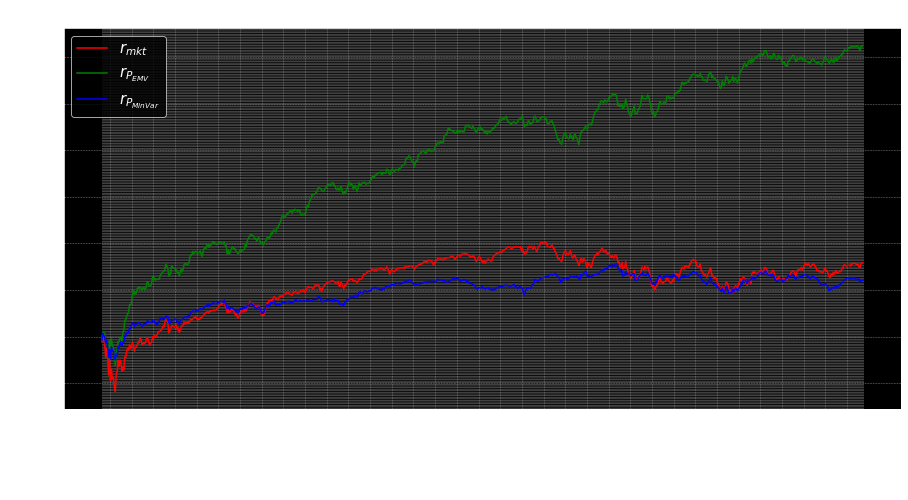

In [6]:
vs.Accum_ts(accum)